array([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [1., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]])

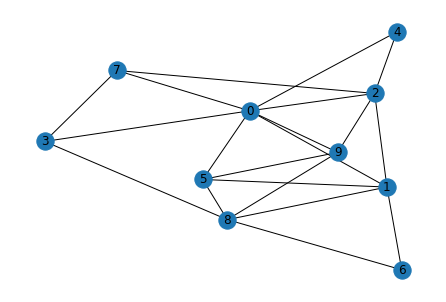

In [25]:
import networkx as nx
import numpy as np
import torch.utils as tutil

np.random.seed(1234)

random_graph = nx.erdos_renyi_graph(10, 0.4)
original_graph = nx.to_numpy_array(random_graph)
nx.draw(random_graph, with_labels=True)
original_graph

## Encoder
 
 Let create test encoder and encoder our random graph first.

In [26]:
from shapgnet.models.adjacency_encoder import AdjacencyEncoder
encoder = AdjacencyEncoder()
encoded_adj = encoder.encode(original_graph.copy(), 10)
encoded_adj

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]])

## Decoder 

Now let's decode our graph back and visualize it and verify 
that we don't have any strange issues.

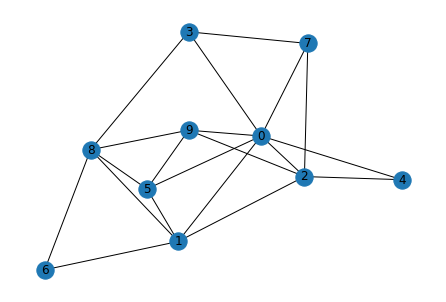

In [27]:
from shapgnet.models.adjacency_decoder import AdjacencyDecoder
decoder = AdjacencyDecoder()
decoded = decoder.decode(encoded_adj)
decoded
decoded_graph = nx.from_numpy_array(decoded, create_using=nx.MultiGraph)
nx.draw(decoded_graph, with_labels=True)

## Metric Computation
Now let compute metric between two graph in simular way as it describe in GraphRNN
and NetGAN paper

In [28]:
from shapgnet.external.graphrnn_eval.stats import degree_stats, clustering_stats, orbit_stats_all
type(decoded_graph)
type(original_graph)
mmd_degree = degree_stats([random_graph], [decoded_graph])
mmd_degree
# This two computation are heavy and I ported C++ code but for now it suffice
# to understand we want compute degree , clustering and orbits between graphs.
# we will use it later to compute metrics.
# mmd_clustering = clustering_stats(original_graph, [decoded_graph])
# mmd_clustering
# mmd_4orbits = orbit_stats_all(original_graph, [decoded_graph])
# mmd_clustering
#

1 1


0.0

## Graph Rnn BFS Ordering.

- In case of Graph RNN we need compute BFS order.
- First let create sample graph lader topology and

Note there are many generators we can use.  Please check for details
https://networkx.org/documentation/stable/reference/generators.html

For this step we only need small graph to undestand how we compute
BFS order at each step.

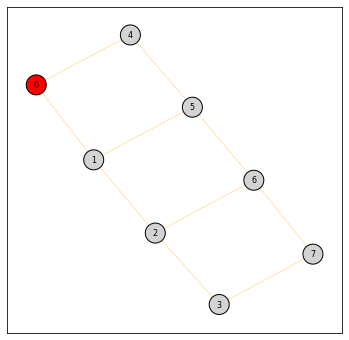

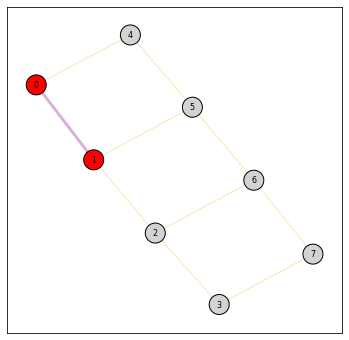

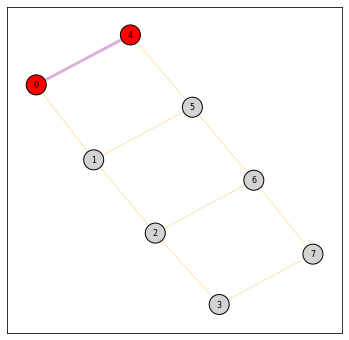

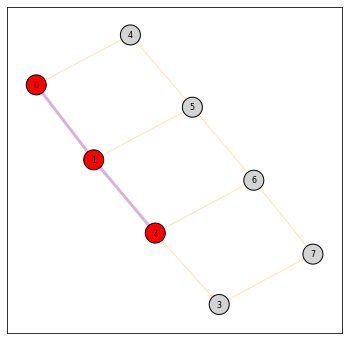

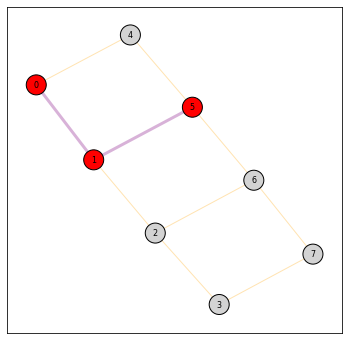

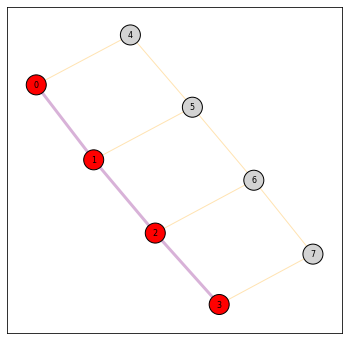

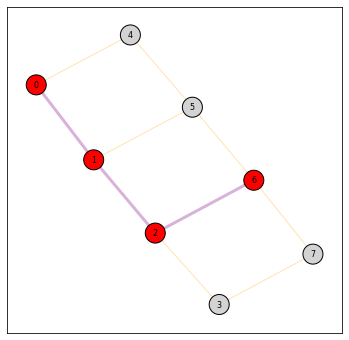

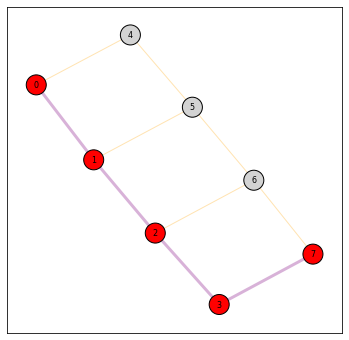

[0, 1, 4, 2, 5, 3, 6, 7]


In [29]:
from queue import LifoQueue as stack
from queue import SimpleQueue as queue

import networkx as nx
import pylab as plt
from IPython.core.display import HTML, display

# import pygraphviz
# from networkx.drawing.nx_agraph import graphviz_layout


def bfs_seq(input_graph, start_id):
    """
     Get a bfs node sequence.

    :param input_graph:
    :param start_id:
    :return:
    """
    dictionary = dict(nx.bfs_successors(input_graph, start_id))
    start = [start_id]
    output = [start_id]

    while len(start) > 0:
        frontier = []
        while len(start) > 0:
            current = start.pop(0)
            neighbor = dictionary.get(current)
            if neighbor is not None:
                frontier = frontier + neighbor
        output = output + frontier
        start = frontier
    return output


def gc(qe):
    if not qe.empty():
        while not qe.empty():
            qe.get()


def bdfs(graph : nx.classes.graph.Graph, start, goal, search='dfs'):
    """
    This is a template. Taking fringe = stack() gives DFS and
    fringe = queue() gives BFS. We need to add a priority function to get UCS.

    Usage: bp = bdfs(graph, start, goal, queue_or_stack = stack()) (this is dfs)
           bp = bdfs(graph, start, goal, queue_or_stack = queue()) (this is bfs)
    """
    depth = {}
    if search == 'dfs':
        queue_or_stack = stack()
        weight = -1
    else:
        queue_or_stack = queue()
        weight = 1

    gc(queue_or_stack)
    current = start
    closed = set()
    back_pointer = {}
    depth[start] = 0
    queue_or_stack.put(current)

    while True:
        if queue_or_stack.empty():
            return None
        while True:
            current = queue_or_stack.get()
            if current not in closed:
                break
            if queue_or_stack.empty():
                return None

        closed.add(current)
        if current == goal:
            return back_pointer

        if graph[current]:
            for node in graph[current]:
                if node not in closed:
                    node_depth = depth[current] + weight
                    if node not in depth or node_depth < depth[node]:
                        back_pointer[node] = current
                        depth[node] = node_depth
                    queue_or_stack.put(node)


def dfs(graph : nx.classes.graph.Graph, start, goal):
    return bdfs(graph, start, goal, search='dfs')


def bfs(graph : nx.classes.graph.Graph, start, goal):
    return bdfs(graph, start, goal, search='bfs')


def get_gr(digraph=True):
    if digraph:
        return nx.DiGraph()
    else:
        return nx.Graph()


def adj2graph(graph : nx.classes.graph.Graph, digraph=True):
    """
    for list representation of adj
    """
    gr = get_gr(digraph=digraph)
    for node in graph:
        gr.add_node(node)
        if graph[node]:
            for adj in graph[node]:
                gr.add_edge(node, adj)
                gr[node][adj]['weight'] = graph[node][adj]
    return gr


def edges_color(graph : nx.classes.graph.Graph, bfs_edge):
    """
    Return edge color and edge weight for a bfs path
    """
    edge_col = ['purple' if e in bfs_edge else 'blue' if e in bfs_edge else 'orange' for e in graph.edges()]
    edge_width = [3 if e in bfs_edge else 1 for e in graph.edges()]
    return edge_col, edge_width


def show_graph(graph : nx.classes.graph.Graph, start: int, goal: int, node_labels='default',
               node_pos='neato', plot_size=(14, 14), file_name=None, is_digraph=True):
    """
    node_labels label to use: 'default', 'none', or a list of labels to use.
    file_name -  a file nama 'my_graph.png'
    """
    fig, ax = plt.subplots(figsize=plot_size)
    Gr = g

    if node_pos == 'project_layout':
        node_pos = dict(zip(Gr.nodes(), [(b, 9 - a) for a, b in Gr.nodes()]))
    else:
        node_pos = nx.nx_pydot.graphviz_layout(Gr, prog=node_pos, root=start)

    edge_weight = nx.get_edge_attributes(Gr, 'weight')

    def path_edges(_path):
        """
        @param _path:
        @return:
        """
        edges = list(zip(_path[:-1], _path[1:]))
        # print(type(Gr[z[0]][z[1])
        # cost = sum([Gr[z[0]][z[1]]['weight'] for z in edges])
        if not is_digraph:
            edges += list(zip(_path[1:], _path[:-1]))
        return edges, 1

    bfs_path = getPath(bdfs(graph, start, goal, search='bfs'), start, goal)
    bfs_edge, bfs_cost = path_edges(bfs_path)

    node_col = ['red' if node in bfs_path else 'lightgray' for node in Gr.nodes()]

    if node_labels == 'default':
        nodes = nx.draw_networkx_nodes(Gr, node_pos, ax=ax, node_color=node_col, node_size=400)
        nodes.set_edgecolor('k')
        nx.draw_networkx_labels(Gr, node_pos, ax=ax, font_size=8)
    elif node_labels == 'none':
        nodes = nx.draw_networkx_nodes(Gr, node_pos, ax=ax, node_color=node_col, node_size=50)
    else:
        # labels must be a list
        nodes = nx.draw_networkx_nodes(Gr, node_pos, ax=ax, node_color=node_col, node_size=400)
        nodes.set_edgecolor('k')
        mapping = dict(zip(Gr.nodes, node_labels))
        nx.draw_networkx_labels(Gr, node_pos, labels=mapping, ax=ax, font_size=8)

    edge_col, edge_width = edges_color(Gr, bfs_edge)

    if is_digraph:
        nx.draw_networkx_edge_labels(Gr, node_pos, ax=ax, label_pos=0.3, edge_labels=edge_weight)
    else:
        nx.draw_networkx_edge_labels(Gr, node_pos, ax=ax, edge_labels=edge_weight)
    nx.draw_networkx_edges(Gr, node_pos, ax=ax, edge_color=edge_col, width=edge_width, alpha=.3)

    if file_name:
        plt.savefig(file_name)

    plt.show()
    display(HTML())


def getPath(bp, start: int, goal : int):
    """
    @param bp: back pointer
    @param start:
    @param goal:
    @return:
    """
    current = goal
    s = [current]
    while current != start:
        current = bp[current]
        s += [current]
    return list(reversed(s))


# create test graph
g = nx.ladder_graph(4)
# get ordered at level bfs
paths = bfs_seq(g, 0)
# display each step
for path in paths:
    show_graph(g, 0, path, plot_size=(6, 6))
# ladder_graph(n)
print(paths)

### Trainer configuration

In [30]:
trainer_config ="""
train: True                 # train or not,  default is True for generation we only need load pre-trained model
active: 'grid_small'        # dataset set generated.
use_model: 'GraphGruRnn'    # model to use , it must be defined in models section.
draw_prediction: True       # at the of training draw.  (TODO here now it will draw last epocs)
load_model: True            # load model or not, and what
load_epoch: 500             # load model.  last epoch
save_model: True            # save model,
regenerate: True            # regenerated,  factor when indicated by epochs_save
active_setting: mini        # indicate what setting to use, so we can switch from debug to production
evaluate: True

early_stopping:
  monitor: loss
  min_delta:
  patience: 100
  mode: max

settings:
  # debug mode
  debug:
    epochs_log:  1000
    start_test:  10
    epochs_test: 10
    epochs_save: 10
  # baseline
  mini:
    # if we need enable early stopping
    early_stopping: True
    epochs_log: 1000
    start_test: 10
    epochs_test: 10
    epochs_save: 50
  # baseline
  baseline:
    early_stopping: True
    epochs_log:  1000
    start_test:  100
    epochs_test: 100
    epochs_save: 100

debug:
  # debug graph generation
  graph_generator: True
  # benchmark dataset loader and sampler, if it true it will return after benchmark
  benchmark_read: False
  # debug model creation
  model_creation: False
  # debug training loops
  train_verbose:  False
  # trace early stopping
  trace_early:    False

training:
  train_ratio: 0.8
  test_ration: 0.8
  validation_ratio: 0.2     # validation ration
  num_workers: 1            # num workers to load data, default 4
  batch_ratio: 32           # num  batches of samples per each epoch, 1 epoch = n batches
  sample_time: 1            # default num sample, note each dataset can overwrite

optimizers:
  node_optimizer:
    eps: 1e-8
    weight_decay: 0
    amsgrad: False
    momentum=0:
    betas: [0.9, 0.999]
    type: Adam
  edge_optimizer:
    eps: 1e-8
    weight_decay: 0
    amsgrad: False
    momentum=0:
    betas: [ 0.9, 0.999 ]
    type: Adam

# lr_schedulers definition
lr_schedulers:
    - type: multistep
      milestones: [ 400, 1000 ]
      name: main_lr_scheduler
    - type: secondary
      milestones: [ 400, 1000 ]
      name: secondary

# Model definition
models:
  # this pure model specific, single model can describe both edges and nodes
  # in case we need use single model for edge and node prediction task ,
  # use keyword single_model: model_name
  GraphGruRnn:
    node_model:
      model: GraphGRU
      optimizer: node_optimizer
      lr_scheduler: main_lr_scheduler
      has_input: True
      has_output: True
    edge_model:
      model: GraphGRU
      optimizer: edge_optimizer
      lr_scheduler: main_lr_scheduler
      input_size: 1
  GraphLstmRnn:
    node_model:
      model: GraphLSTM
      optimizer: node_optimizer
      lr_scheduler: main_lr_scheduler
      has_input: True
      has_output: True
    edge_model:
      model: GraphLSTM
      optimizer: edge_optimizer
      lr_scheduler: main_lr_scheduler
      input_size: 1

plots:
  limit: 100

metrics:
  degree: True
  orbits: True
  clustering: True

trace_prediction_timer: True
trace_training_timer: True
trace_epocs: 1

graph:
   # multiplied (640x10 and 15x32)

  # Generated Grid
  grid:
    # https://networkx.org/documentation/stable/reference/generated/networkx.generators.lattice.grid_2d_graph.html
    epochs: 100
    parameter_shrink: 1
    batch_size: 32
    test_batch_size: 32
    test_total_size: 1000
    num_layers: 4
    lr: 0.003
    milestones: [ 400, 1000 ]
    lr_rate: 0.3
    graph_spec:
      grid_n: [ 10, 20 ]
      grid_m: [ 10, 20 ]
    max_num_node: 0
    max_prev_node: 40
  # just to test code logic
  grid_min:
    epochs: 100
    parameter_shrink: 2
    batch_size: 32
    test_batch_size: 32
    test_total_size: 1000
    num_layers: 4
    lr: 0.003
    milestones: [ 400, 1000 ]
    lr_rate: 0.3
    graph_spec:
      grid_n: [ 2, 5 ]
      grid_m: [ 2, 6 ]
    #    max_num_node: 10
    max_prev_node: 15
  grid_small:
    epochs: 500
    parameter_shrink: 2
    batch_size: 32
    test_batch_size: 32
    test_total_size: 1000
    num_layers: 4
    lr: 0.003
    milestones: [ 400, 1000 ]
    lr_rate: 0.3
    graph_spec:
      grid_n: [ 2, 5 ]
      grid_m: [ 2, 6 ]
#    max_num_node: 10
    max_prev_node: 15
  # Generated Community
  caveman:
    epochs: 20
    parameter_shrink: 1
    batch_size: 32
    test_batch_size: 32
    test_total_size: 1000
    num_layers: 4
    lr: 0.003
    milestones: [ 400, 1000 ]
    lr_rate: 0.3
    graph_spec:
      size_of_cliques: 10
      num_of_cliques_i: [ 2, 3 ]
      num_of_cliques_j: [ 30, 81 ]
      p_edge: 0.8
    # max number num nodes
    max_num_node: 100
    # max nodes
    max_prev_node: 100
  # small caveman community network.
  # check networkx doc for details
  caveman_small:
    epochs: 20
    num_layers: 4
    parameter_shrink: 2
    test_batch_size: 32
    test_total_size: 1000
    batch_size: 32
    milestones: [ 400, 1000 ]
    lr: 0.003
    lr_rate: 0.3
    # graph specs
    graph_spec:
      size_of_cliques: 20
      num_of_cliques_i: [2, 3]
      num_of_cliques_j: [6, 11]
      p_edge: 0.3
      # max number num nodes
    max_num_node: 20
    # max nodes
    max_prev_node: 20

root_dir: "."
log_dir: "logs"
nil_dir: "timing"
graph_dir: "graphs"
results_dir: "results"
timing_dir: "timing"
figures_dir: "figures"
prediction_dir: "prediction"                     # where we save prediction
model_save_dir: "model_save"                     # where we save model
#figures_prediction_dir: "prediction_figures"    #
"""

Let's create model trainer class


In [31]:
import io
from shapgnet.model_config import ModelSpecs
trainer_spec = ModelSpecs(template_file_name=io.StringIO(trainer_config), verbose=True)
model_specs = trainer_spec.get_active_model_spec()
model_specs

Device:                          cuda
Reading from io buffer


{
    'node_model': {
        'model': 'GraphGRU',
        'optimizer': 'node_optimizer',
        'lr_scheduler': 'main_lr_scheduler',
        'has_input': True,
        'has_output': True
    },
    'edge_model': {
        'model': 'GraphGRU',
        'optimizer': 'edge_optimizer',
        'lr_scheduler': 'main_lr_scheduler',
        'input_size': 1
    }
}

Let define main traning loop

In [32]:
import sys
from shapgnet.models.sampler.GraphSeqSampler import GraphSeqSampler
import argparse
import random
import sys
import time
from datetime import time
from datetime import timedelta
from typing import Final

import numpy as np
import torch
import torch.utils as tutil
import pandas as pd

from shapgnet import create_graphs
from shapgnet.external.graphrnn_eval.stats import degree_stats, clustering_stats, orbit_stats_all
from shapgnet.generator_trainer import GeneratorTrainer
from shapgnet.model_config import ModelSpecs
from shapgnet.model_creator import ModelCreator
from shapgnet.models.adjacency_decoder import AdjacencyDecoder
from shapgnet.models.sampler.GraphSeqSampler import GraphSeqSampler
from shapgnet.plotlib import plot
from shapgnet.plotlib.plot import draw_single_graph
from shapgnet.utils import fmt_print, fmtl_print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


TRAIN: Final = 1
TEST: Final = 2
PREDICTION: Final = 3


def generate_train_test(g, specs: ModelSpecs, is_fix_seed=True, is_shuffled=True):
    """
    Generate test , train , validation split
    """
    # split datasets
    if is_fix_seed:
        random.seed(123)

    if is_shuffled:
        random.shuffle(g)

    graphs_len = len(g)
    return g[int(specs.test_ratio() * graphs_len):], \
           g[0:int(specs.train_ratio() * graphs_len)], \
           g[0:int(specs.validation_ratio() * graphs_len)]

def compute_graph_split_len(gv, gt):
    """
    Compute split based on number of nodes and edges

    and return normalized value.
    @param gv:
    @param gt:
    @return:
    """

    return sum(g.number_of_nodes() for g in gv) / len(gv), \
           sum(g.number_of_nodes() for g in gt) / len(gt)

def draw_samples(trainer_spec: ModelSpecs, from_epoch=None, limit=None, graph_type=TRAIN,
                 num_samples=10):
    """

     Reads spool dir for generated sample and plot each.

    """
    fmtl_print("Train graph", trainer_spec.get_active_train_graph())
    fmtl_print("Train graph spec", trainer_spec.get_active_train_graph_spec())
    fmtl_print("Prediction files", trainer_spec.get_active_model_prediction_files())
    fmtl_print("Last saved epoch", trainer_spec.get_last_saved_epoc())
    fmtl_print("Last graph stat", trainer_spec.get_last_graph_stat())

    last_saved_epoch = trainer_spec.get_last_saved_epoc()['node_model']
    graphs = trainer_spec.get_last_graph_stat()

    for i, g in enumerate(graphs):
        file_name = trainer_spec.generate_prediction_figure_name(last_saved_epoch, sample_time=1, gid=i)
        draw_single_graph(g, file_name=file_name, plot_type='prediction', graph_name="test")

def prepare(trainer_spec : ModelSpecs):
    """
    Prepare dir , clean up etc.
    """
    trainer_spec.build_dir()
    trainer_spec.setup_tensorflow()


def create_dataset_sampler(trainer_spec: ModelSpecs, graphs, num_workers=None):
    """

    @param trainer_spec: trainer specification, include strategy how to sample ration etc.
    @param graphs: a graph that we use to train network
    @param num_workers:
    @return: return torch.util.data.DataLoader
    """
    # dataset initialization
    if trainer_spec.max_prev_node() > 0:
        dataset = GraphSeqSampler(graphs,
                                  max_prev_node=trainer_spec.max_prev_node(),
                                  max_num_node=trainer_spec.max_num_node())
    else:
        dataset = GraphSeqSampler(graphs)

    normalized_weight = [1.0 / len(dataset) for i in range(len(dataset))]
    sample_strategy = tutil.data.sampler.WeightedRandomSampler(normalized_weight,
                                                               num_samples=trainer_spec.compute_num_samples(),
                                                               replacement=True)

    _num_workers = trainer_spec.num_workers()
    if num_workers is not None:
        _num_workers = num_workers

    dataset_loader = tutil.data.DataLoader(dataset,
                                           batch_size=trainer_spec.batch_size(),
                                           num_workers=_num_workers,
                                           sampler=sample_strategy,
                                           pin_memory=False)

    return dataset_loader


def clean_graphs(graph_real, graph_pred, is_shuffle=True):
    """
    Selecting graphs generated that have the similar sizes.
    It is usually necessary for GraphRNN-S version, but not the full GraphRNN model.
    """

    #
    if is_shuffle:
        random.shuffle(graph_real)
        random.shuffle(graph_pred)

    # get length
    real_graph_len = np.array([len(graph_real[i]) for i in range(len(graph_real))])
    pred_graph_len = np.array([len(graph_pred[i]) for i in range(len(graph_pred))])

    fmt_print("Real graph size", real_graph_len)
    fmt_print("Prediction graph size", pred_graph_len)

    # # select pred samples
    # # The number of nodes are sampled from the similar distribution as the training set
    # pred_graph_new = []
    # pred_graph_len_new = []
    # for value in real_graph_len:
    #     pred_idx = find_nearest_idx(pred_graph_len, value)
    #     pred_graph_new.append(graph_pred[pred_idx])
    #     pred_graph_len_new.append(pred_graph_len[pred_idx])
    # return graph_real, pred_graph_new


def compute_generic_stats(epoch_predicted):
    """

    """
    graph_pred_aver = 0
    for graph in epoch_predicted:
        graph_pred_aver += graph.number_of_nodes()

    graph_pred_aver /= len(epoch_predicted)
    fmt_print('Prediction average number of nodes', graph_pred_aver)


def evaluate(cmds, trainer_spec: ModelSpecs,
             epoch_start=1,
             epoch_step=1):
    # get a graphs
    try:
        train_graph, graph_in_test = trainer_spec.load_train_test()
        graph_test_len = len(train_graph)
    except FileNotFoundError:
        print("No graph file found.")
        return

    graph_train = train_graph[0:int(0.8 * graph_test_len)]  # train
    # graph_validate = train_graph[0:int(0.2 * graph_test_len)]  # validate
    # graph_test = train_graph[int(0.8 * graph_test_len):]       # test on a hold out test set

    graph_test_aver = 0
    for graph in graph_in_test:
        graph_test_aver += graph.number_of_nodes()

    graph_test_aver /= len(graph_in_test)

    print('test average len', graph_test_aver)
    predictions = trainer_spec.get_prediction_graph()

    # x_df = pd.DataFrame(x_np)

    # x_np = x.numpy()
    for i, (file_name, epoch_predicted) in enumerate(predictions):
        if i < 27:
            continue

        print(i, file_name)
        print("Computing statistic for", file_name)
        # get filename
        # fname_pred = trainer_spec.prediction_filename(epoch, sample_time)
        # graph_pred = load_graph_from_file(fname_pred, is_real=False)
        #
        # clean graphs
        # if is_clean:
        #     graph_test, graph_pred = clean_graphs(graph_test, graph_pred)
        # else:
        #     shuffle(graph_pred)
        #     graph_pred = graph_pred[0:len(graph_test)]
        #
        fmt_print('Graph in test:', len(graph_in_test))
        fmt_print('Graph in prediction:', len(epoch_predicted))

        #
        compute_generic_stats(epoch_predicted)
        clean_graphs(graph_in_test, epoch_predicted)

        #
        # # evaluate MMD test
        mmd_degree = -1
        if trainer_spec.mmd_degree():
            mmd_degree = degree_stats(graph_in_test, epoch_predicted)
            fmt_print('Evaluated MMD:', mmd_degree)
        #
        mmd_clustering = -1
        if trainer_spec.mmd_clustering():
            mmd_clustering = clustering_stats(graph_in_test, epoch_predicted)
            fmt_print('Graph clustering:', mmd_clustering)
        #
        mmd_4orbits = -1
        if trainer_spec.mmd_orbits():
            mmd_orbits = orbit_stats_all(graph_in_test, epoch_predicted)
            fmt_print('Graph orbit:', mmd_4orbits)

        # x_np = [i] = [mmd_degree, mmd_clustering, mmd_orbits]
        print('degree', mmd_degree, 'clustering', mmd_clustering, 'orbits', mmd_4orbits)

    # x_df.to_csv('tmp.csv')


def main_train(cmds, trainer_spec: ModelSpecs):
    """

    """
    # prepare test environment
    prepare(trainer_spec)

    # create model creator
    model_creator = ModelCreator(trainer_spec, device)

    # model graph specs
    print("###############################################")
    fmtl_print("Creating graphs type", trainer_spec.active)
    fmtl_print("Maximum previous node to track", trainer_spec.max_prev_node())
    fmtl_print("Maximum nodes to track", trainer_spec.max_num_node())

    # create dataset based on specs in config.yaml
    graph_spec = trainer_spec.max_prev_node()
    graphs = create_graphs.create(trainer_spec)
    max_num_node = max([graphs[i].number_of_nodes() for i in range(len(graphs))])
    min_num_edge = min([graphs[i].number_of_edges() for i in range(len(graphs))])
    max_num_edge = max([graphs[i].number_of_edges() for i in range(len(graphs))])

    trainer_spec.trainer_spec = trainer_spec.set_max_num_node(max_num_node)
    #
    fmtl_print('traing/test/val ratio', trainer_spec.train_ratio(),
               trainer_spec.test_ratio(), trainer_spec.validation_ratio())
    fmtl_print('max previous node', trainer_spec.max_prev_node())
    fmtl_print('max number node', trainer_spec.max_num_node())
    fmtl_print('max/min number edge', max_num_edge, min_num_edge)

    # compute splits
    graphs_test, graphs_train, graphs_validate = generate_train_test(graphs, trainer_spec)
    graph_validate_len, graph_test_len = compute_graph_split_len(graphs_validate, graphs_test)
    fmtl_print('total/train/test/validate sizes', len(graphs), len(graphs_train), len(graphs_test),
               len(graphs_validate))
    fmtl_print('validation/test', graph_validate_len, graph_test_len)
    fmtl_print('total graph number, training subset', len(graphs), len(graphs_train))
    print("###############################################")

    # load_pretrained(trainer_spec)
    # save ground truth graphs
    # To get train and test set, after loading you need to manually slice
    GeneratorTrainer.save_graphs(graphs, str(trainer_spec.train_graph_file()))
    GeneratorTrainer.save_graphs(graphs, str(trainer_spec.test_graph_file()))

    # plot training set if needed
    if cmds is not None and cmds.plot == 'train':
        plot.draw_samples_from_file(trainer_spec.train_graph_file(), plot_type='train',
                                    file_prefix=trainer_spec.train_plot_filename(),
                                    num_samples=10)

    dataset_loader = create_dataset_sampler(trainer_spec, graphs_train)

    if trainer_spec.is_read_benchmark():
        read_start_timer = time.monotonic()
        for _, _ in enumerate(dataset_loader):
            pass
        read_stop_timer = time.monotonic()
        fmt_print("Dataset read time", timedelta(seconds=read_stop_timer - read_start_timer), "sec")
        return

    models = model_creator.create_model(verbose=True)
    if trainer_spec.is_train_network():
        decoder = AdjacencyDecoder()
        trainer = model_creator.create_trainer(dataset_loader, models, decoder)
        trainer.train()


def main_trainer(trainer_spec: ModelSpecs):
    """
    Main entry
    @param cmds:
    @param trainer_spec:
    @return:
    """

    if trainer_spec.is_train_network():
        main_train(None, trainer_spec)

    if trainer_spec.is_draw_samples():
        if not trainer_spec.is_trainer():
            sys.exit("Check configuration file,  it looks like model {} "
                     "is untrained.".format(trainer_spec.get_active_model()))
        draw_samples(trainer_spec)

    if trainer_spec.is_evaluate():
        if not trainer_spec.is_trainer():
            sys.exit("Check configuration file,  it looks like model {} "
                     "is untrained.".format(trainer_spec.get_active_model))
        evaluate(None, trainer_spec)

In [ ]:
trainer_spec = ModelSpecs(template_file_name=io.StringIO(trainer_config), verbose=True)
model_specs = trainer_spec.get_active_model_spec()
model_specs

fmtl_print("Torch cudnn backend version: ", torch.backends.cudnn.version())
fmtl_print("Model in training mode", trainer_spec.is_train_network())
fmtl_print("Model in evaluate mode", trainer_spec.is_evaluate())
fmtl_print("Model in generate sample", trainer_spec.is_draw_samples())
fmtl_print("Model active dataset", trainer_spec.active)
fmtl_print("Model active dataset", trainer_spec.epochs())
fmtl_print("Model active dataset", trainer_spec.batch_size())
fmtl_print("Model number of layers", trainer_spec.num_layers())
fmtl_print("Active model", trainer_spec.active_model)

# run
main_trainer(trainer_spec)

Device:                          cuda
Reading from io buffer
Torch cudnn backend version: :   8200
Model in training mode:          True
Model in evaluate mode:          True
Model in generate sample:        True
Model active dataset:            grid_small
Model active dataset:            500
Model active dataset:            32
Model number of layers:          4
Active model:                    GraphGruRnn
tensorboard log dir:      logs
###############################################
Creating graphs type:            grid_small
Maximum previous node to track:  15
Maximum nodes to track:          0
Generating grid graph type: backend nx
Synthetic grid's n and m: ([2, 5], [2, 6])
traing/test/val ratio:           (0.8, 0.8, 0.2)
max previous node:               15
max number node:                 20
max/min number edge:             (31, 4)
total/train/test/validate sizes: (12, 9, 3, 2)
validation/test:                 (12.0, 5.333333333333333)
total graph number, training subset: (12, 9)
#

  0%|          | 0/500 [00:00<?, ?it/s]

Saving graph image, type training to tensorboard
Saving graph to a file :  results\prediction\grid_small_GraphGruRnn__layers_4_hidden_64_predictions_epoch_10_sample_1.dat
Saving graph image, type training to tensorboard
Saving graph to a file :  results\prediction\grid_small_GraphGruRnn__layers_4_hidden_64_predictions_epoch_10_sample_2.dat
Saving graph image, type training to tensorboard
Saving graph to a file :  results\prediction\grid_small_GraphGruRnn__layers_4_hidden_64_predictions_epoch_10_sample_3.dat
Saving graph image, type training to tensorboard
Saving graph to a file :  results\prediction\grid_small_GraphGruRnn__layers_4_hidden_64_predictions_epoch_20_sample_1.dat
Saving graph image, type training to tensorboard
Saving graph to a file :  results\prediction\grid_small_GraphGruRnn__layers_4_hidden_64_predictions_epoch_20_sample_2.dat
Saving graph image, type training to tensorboard
Saving graph to a file :  results\prediction\grid_small_GraphGruRnn__layers_4_hidden_64_predicti